In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw, ImageOps 
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import  plot_model
import tensorflow as tf
import json
import os
from os import listdir
import cv2
import random
H, W = 224, 224
n_sample =  5000
batch_size = 64

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
os.getcwd()

Num GPUs Available:  0


'C:\\Users\\amira\\OneDrive\\Desktop\\computervision_task3'

In [220]:
n_sample

5000

In [229]:
X = np.empty([n_sample, H , W, 3])
y = np.empty([n_sample, 8])

# Loading images and coordinates
def flatten_cordinates(cordinate):
    return np.array( cordinate[0][0] + cordinate[1][0] + cordinate[2][0] + cordinate[3][0])
with open('coordinates.json') as f:
    coordinate_data = json.load(f)
for i in coordinate_data.keys():
    coordinate_data[i].sort()
    coordinate_data[i] = flatten_cordinates(coordinate_data[i])

image_dir = "data"
for image in os.listdir(image_dir):
    i = image.split('.')[0]
    sample_img = keras.preprocessing.image.load_img(image_dir+'/' + image, 0)
    sample_img = keras.preprocessing.image.img_to_array(sample_img)
    X[int(i), :, :, :] = tf.keras.applications.mobilenet.preprocess_input(sample_img)
    y[int(i)] = coordinate_data[i] / H # normalizing the output
      




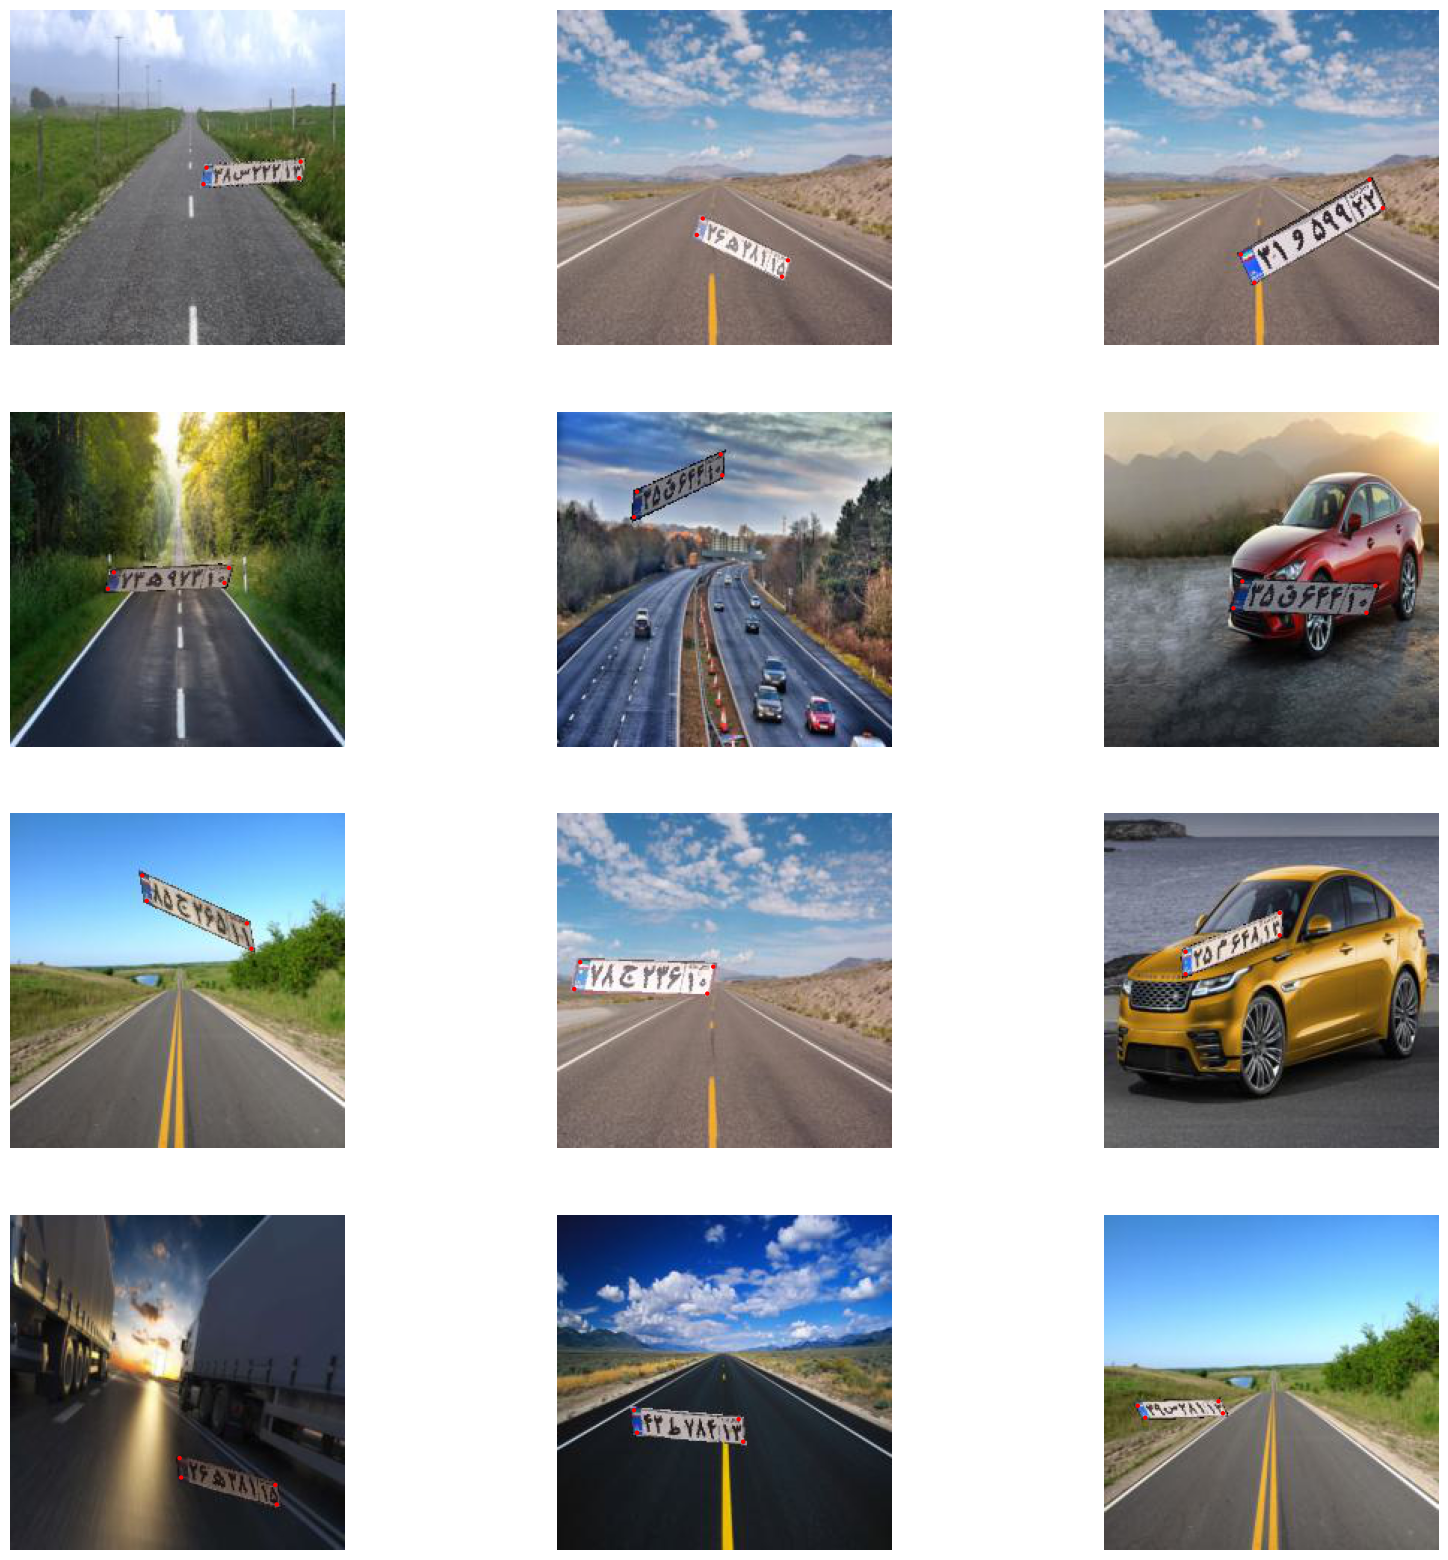

In [230]:
import matplotlib.pyplot as plt
#from matplotlib.pyplot import figure
row = 4
col = 3
figure, axis = plt.subplots(row,col,figsize=(20, 20))

for i in range(row):
    for j in range(col):
        k = random.randint(0,n_sample-1)
        k_c = np.floor(y[k].copy() * H)
        circle1  = plt.Circle((k_c[0],k_c[1]), 1., color='r')  
        axis[i,j].add_patch(circle1)
        circle1  = plt.Circle((k_c[2],k_c[3]), 1., color='r')   
        axis[i,j].add_patch(circle1)
        circle1  = plt.Circle((k_c[4],k_c[5]), 1., color='r')   
        axis[i,j].add_patch(circle1)
        circle1  = plt.Circle((k_c[6],k_c[7]), 1., color='r')   
        axis[i,j].add_patch(circle1)
        axis[i,j].imshow((X[k]+1)/2)
        axis[i,j].axis(False)


In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

class DataGenerator(keras.utils.Sequence):
    def __init__(self, x_data, y_data, batch_size):
        self.x, self.y = x_data, y_data
        self.batch_size = batch_size
        self.num_batches = np.ceil(len(x_data) / batch_size)
        self.batch_idx = np.array_split(range(len(x_data)), self.num_batches)

    def __len__(self):
        return len(self.batch_idx)

    def __getitem__(self, idx):
        batch_x = self.x[self.batch_idx[idx]]
        batch_y = self.y[self.batch_idx[idx]]
        return batch_x, batch_y
    
    
train_generator = DataGenerator(X_train, y_train, batch_size)
test_generator = DataGenerator(X_test, y_test, batch_size)


In [256]:
json_file = open('mobilenetv.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
mobilenet = model_from_json(loaded_model_json)
# load weights into new model
mobilenet.load_weights("mobilenetv.h5")
print("Mobilenet has been Loaded model from disk")

Mobilenet has been Loaded model from disk


In [257]:
for x, y in train_generator:
    res = mobilenet(x)
    print(y.shape)
    break

(64, 8)


In [258]:
extend_ = Flatten()(mobilenet.output)
extend_ = Dense(8, activation='sigmoid')(extend_)
model = Model(mobilenet.input, extend_)


model.compile(loss= 'mean_squared_error', optimizer=Adam(learning_rate=0.0001))


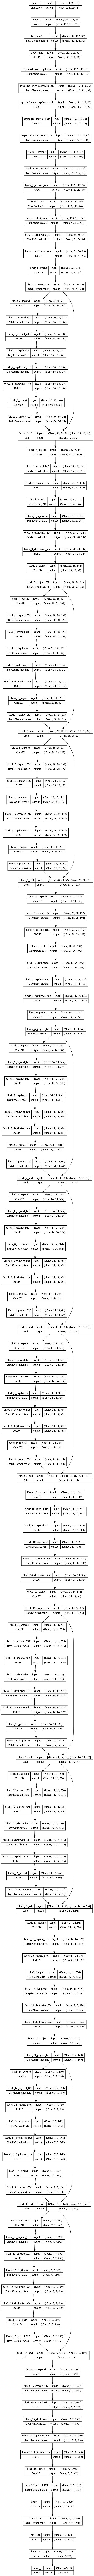

In [251]:
plot_model(model, "first_model.png",show_shapes=True,expand_nested=False)

In [252]:
model(x).shape

TensorShape([64, 8])

In [261]:
model.fit(train_generator,epochs=1 , steps_per_epoch = 15)


15/15 [==============================] - 35s 2s/step - loss: 0.0896


In [236]:
model.evaluate(test_generator, verbose=2)


16/16 - 9s - loss: 0.1227 - 9s/epoch - 574ms/step


0.12267810106277466

In [242]:
y_predicted = model.predict(test_generator, verbose = 2 )

16/16 - 8s - 8s/epoch - 486ms/step


In [254]:
((y_ - y_predicted)**2).sum(axis = 1)

array([1.84879252, 1.05720283, 1.75259318, 1.59747688, 1.3919603 ,
       1.5294772 , 1.92186092, 1.21578045, 0.66117667, 1.60362686,
       1.65001196, 1.30628076, 0.71484375, 1.66107913, 1.16078957,
       1.6853438 , 1.65701758, 1.64264163, 1.35145984, 1.07708865,
       1.44433594, 1.36254385, 1.5308514 , 1.54861268, 1.09630102,
       1.1932398 , 1.38392857, 1.11248406, 0.93590561, 0.92653858,
       0.98620855, 1.44826212, 0.9948581 , 1.46512277, 1.6069037 ,
       0.61734694, 1.2911352 , 0.84064094, 0.9167331 , 1.44866007,
       1.61182498, 1.45420121, 0.61387915, 1.39612564, 1.16603727,
       1.37972337, 1.43391263, 1.77699893, 1.25757334, 1.56002009,
       0.93351403, 1.70681895, 1.52601786, 1.63519822, 1.46688598,
       1.24641263, 0.76751811, 1.32421875, 1.50766973, 1.44335937,
       0.9732102 , 1.18064413, 1.30831473])

In [150]:
i -=1
(( y_[i,:] - y_predicted[i,:] )**2).sum()

C:\Users\amira\AppData\Local\Temp\ipykernel_11852\1075935108.py:2: RuntimeWarning: invalid value encountered in subtract
  (( y_[i,:] - y_predicted[i,:] )**2).sum()


nan

2/2 [==============================] - 0s 255ms/step


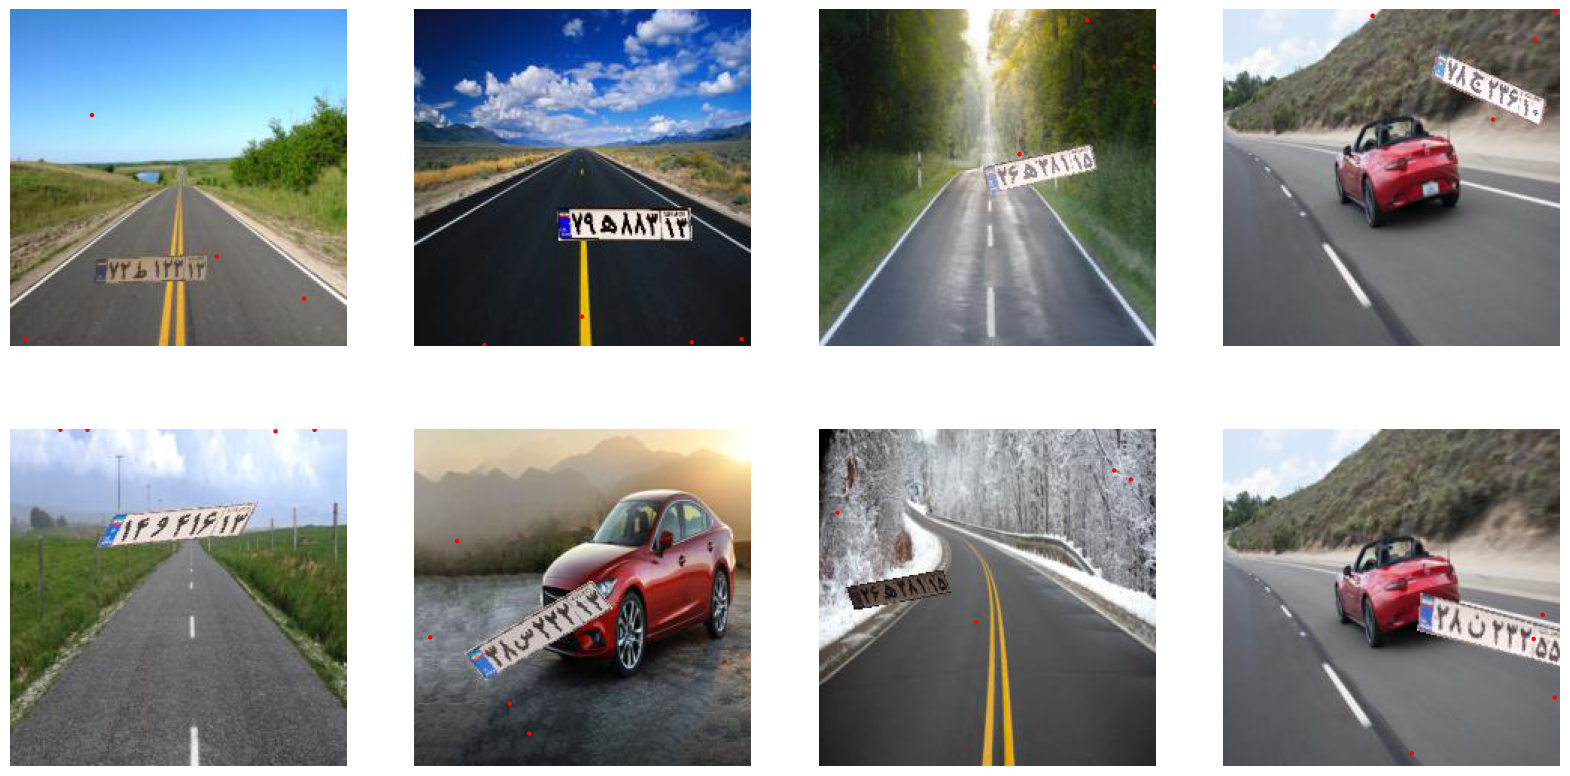

In [262]:
#from matplotlib.pyplot import figure

X_ ,y_ = next(iter(test_generator))
y_predicted = model.predict(X_)
row = 2
col = 4
figure, axis = plt.subplots(row,col,figsize=(20, 10))

for i in range(row):
    for j in range(col):
        k = random.randint(0, X_.shape[0] -1)
        k_c = np.floor(y_predicted[k].copy() * H)
        circle1  = plt.Circle((k_c[0],k_c[1]), 1., color='r')  
        axis[i,j].add_patch(circle1)
        circle1  = plt.Circle((k_c[2],k_c[3]), 1., color='r')   
        axis[i,j].add_patch(circle1)
        circle1  = plt.Circle((k_c[4],k_c[5]), 1., color='r')   
        axis[i,j].add_patch(circle1)
        circle1  = plt.Circle((k_c[6],k_c[7]), 1., color='r')   
        axis[i,j].add_patch(circle1)
        axis[i,j].imshow((X_[k]+1)/2)
        axis[i,j].axis(False)

In [44]:
batch_size

128